### AI Assistance Disclosure
I used ChatGPT lightly for: (a) MAPIE usage pattern for prediction
intervals, (b) the alpha→coverage evaluation loop, and (c) a small helper to map
one-hot feature names for the importance plot. I verified and edited all code. 
Structure follows our course materials.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import json
import pickle
import warnings
warnings.filterwarnings("ignore")

# sklearn pipeline pieces
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost regressor
from xgboost import XGBRegressor

# MAPIE for prediction intervals
from mapie.regression import MapieRegressor

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load dataset & quick inspect

In [3]:
df = pd.read_csv("Traffic_Volume.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


Pick target and features

In [4]:
# find the target column automatically
lower_cols = {c.lower(): c for c in df.columns}
candidates = [k for k in lower_cols if k in ("traffic_volume", "traffic volume", "volume")]
if not candidates:
    raise ValueError("Target not found. Rename target to 'traffic_volume' or 'volume'.")

target_col = lower_cols[candidates[0]]
y = df[target_col].astype(float)

# drop target and obvious timestamp columns
drop_cols = [target_col]
for c in df.columns:
    cl = c.lower()
    if "date" in cl or "time" in cl or "datetime" in cl:
        drop_cols.append(c)

X = df.drop(columns=drop_cols).copy()
X.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main
0,NaN,288.28,0.0,0.0,40,Clouds
1,NaN,289.36,0.0,0.0,75,Clouds
2,NaN,289.58,0.0,0.0,90,Clouds
3,NaN,290.13,0.0,0.0,90,Clouds
4,NaN,291.14,0.0,0.0,75,Clouds


Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X.shape, X_train.shape, X_test.shape

((48204, 6), (38563, 6), (9641, 6))

In [ ]:
# Cardinality check
cat_raw = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
card = pd.Series({c: X[c].nunique(dropna=True) for c in cat_raw}).sort_values(ascending=False)
display(card.head(20))

holiday         11
weather_main    11
dtype: int64

Preprocessing + XGB Pipeline

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))

# Numeric: median impute
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

# Categorical: impute, then Ordinal encode to compact ints
# Unknowns mapped to -1 to avoid errors at predict time
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0  # has no effect now, but fine to keep
)

from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",
    tree_method="hist"   # memory-friendly
)

pipe = Pipeline([
    ("prep", preprocess),
    ("reg", xgb),
])

Numeric: 4 | Categorical: 2


MAPIE FIT + 90% Prediction Interval

In [ ]:
from sklearn.model_selection import train_test_split
from mapie.regression import MapieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Fit the pipeline on a TRAIN subset 
X_tr, X_cal, y_tr, y_cal = train_test_split(
    X_train, y_train,
    test_size=min(2000, max(200, int(0.2 * len(X_train)))) ,  # cap calibration ~2k rows
    random_state=42
)

pipe.fit(X_tr, y_tr)

# Wrap with MAPIE using prefit mode, and fit ONLY on the small calibration set
mapie = MapieRegressor(
    estimator=pipe,
    method="plus",
    cv="prefit",           
    agg_function="median",
    random_state=42
)
mapie.fit(X_cal, y_cal)    

# Evaluate on test with 90% PI
alpha_default = 0.10
y_pred, y_pis = mapie.predict(X_test, alpha=alpha_default)
y_lo, y_hi = y_pis[:, 0, 0], y_pis[:, 1, 0]

# metrics 
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Model Performance (90% PI)")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.3f}")
print(f"Calib size used by MAPIE: {len(X_cal)}")

Model Performance (90% PI)
RMSE : 1862.63
MAE  : 1590.91
R²   : 0.122
Calib size used by MAPIE: 2000


Feature Importance (Top 25)

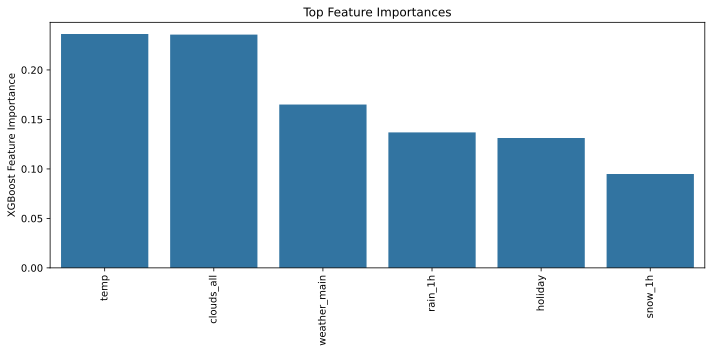

In [29]:
pipe_all = Pipeline([("prep", preprocess), ("reg", xgb)])
pipe_all.fit(X, y)

feat_names = (
    X.select_dtypes(include=["number"]).columns.tolist()
    + X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
)

imp = pipe_all.named_steps["reg"].feature_importances_
order = np.argsort(imp)[::-1]

plt.figure(figsize=(10, 5))
topk = min(25, len(feat_names))
sns.barplot(x=np.array(feat_names)[order][:topk], y=imp[order][:topk])
plt.xticks(rotation=90)
plt.ylabel("XGBoost Feature Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.svg")
plt.show()

Residual Histogram

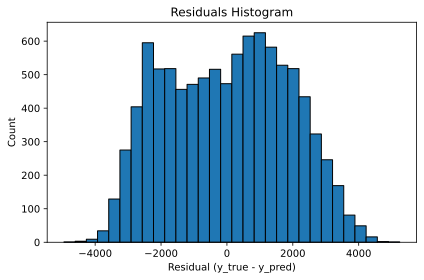

In [30]:
resid = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=30, edgecolor="black")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.tight_layout()
plt.savefig("residual_hist.svg")
plt.show()

Predicted vs Actual

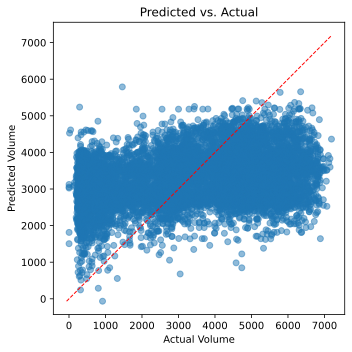

In [31]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Predicted vs. Actual")
plt.tight_layout()
plt.savefig("pred_vs_actual.svg")
plt.show()

Coverage vs Nominal

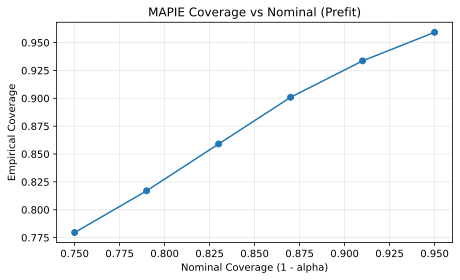

In [32]:
alphas = np.linspace(0.05, 0.25, 6)  # 95%→75% nominal
y_pred_all, y_pis_all = mapie.predict(X_test, alpha=alphas)

y_lo_all = y_pis_all[:, 0, :]
y_hi_all = y_pis_all[:, 1, :]
y_true_col = y_test.values[:, None]

cover = ((y_true_col >= y_lo_all) & (y_true_col <= y_hi_all)).mean(axis=0)
pi_width = (y_hi_all - y_lo_all).mean(axis=0)

plt.figure(figsize=(6.5, 4))
plt.plot(1 - alphas, cover, marker="o")
plt.xlabel("Nominal Coverage (1 - alpha)")
plt.ylabel("Empirical Coverage")
plt.title("MAPIE Coverage vs Nominal (Prefit)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("coverage_plot.svg")
plt.show()

Save Artifacts for App

In [33]:
import json, pickle

with open("xgb_traffic.pickle", "wb") as f:
    pickle.dump(pipe_all, f)

with open("mapie_traffic.pickle", "wb") as f:
    pickle.dump(mapie, f)

metrics = {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}
with open("traffic_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

["xgb_traffic.pickle","mapie_traffic.pickle","feature_importance.svg",
 "residual_hist.svg","pred_vs_actual.svg","coverage_plot.svg","traffic_metrics.json"]

['xgb_traffic.pickle',
 'mapie_traffic.pickle',
 'feature_importance.svg',
 'residual_hist.svg',
 'pred_vs_actual.svg',
 'coverage_plot.svg',
 'traffic_metrics.json']

Sample Predictions for User CSV

In [34]:
alpha_default = 0.10  # keep same default used above

user_df = pd.read_csv("traffic_data_user.csv")
y_pred_user, y_pis_user = mapie.predict(user_df, alpha=alpha_default)

user_out = user_df.copy()
user_out["Predicted Volume"] = y_pred_user
user_out["Lower PI"] = y_pis_user[:, 0, 0]
user_out["Upper PI"] = y_pis_user[:, 1, 0]

user_out.to_csv("user_predictions_example.csv", index=False)
user_out.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,weekday,hour,Predicted Volume,Lower PI,Upper PI
0,NaN,289.49,0.0,0.0,1,Fog,July,Friday,7,2080.150635,-869.407471,5029.708740
1,NaN,279.35,0.0,0.0,1,Clear,October,Monday,21,2955.932373,6.374268,5905.490479
2,NaN,291.39,0.0,0.0,36,Clouds,June,Wednesday,0,2313.702393,-635.855713,5263.260498
3,NaN,294.02,0.0,0.0,90,Thunderstorm,July,Wednesday,22,2955.404297,5.846191,5904.962402
4,NaN,268.69,0.0,0.0,64,Mist,December,Friday,9,2884.164795,-65.393311,5833.722900
